# Plotting Vector Winds with Basemap
When plotting vector quantities (wind barbs, quivers, or streamlines) on a map, you need to consider both the dataset's vector frame of reference and the map projection. GRIB2 model U and V components are either _grid relative_ or _earth relative_.

- **Grid Relative**: The U component points in the left-right direction relative to the model domain's grid and V points in the top-bottom direction.
- **Earth Relative**: The U component points in the east-west direction and V points in the north-south direction.

You can check if a GRIB2 file is earth or grid relative like this:
    
    wgrib2 -vector_dir [file_name]
    
Before plotting vectors on Matplotlib's Basemap, you need to be aware of the model data's vector direction and the map's projection you are using before applying `m.barbs` or `m.quiver` to your figure. You _don't_ have to transform the data **only if you are plotting the vectors on the same map projection as the model**. You _do_ have to transfor the data if you are changing the projection from the original model grid.

Basemap's method `rotate_vector()` takes _earth relative_ vectors and rotates them appropriatly for the map projection. According to the Basemap documentation [[1](https://matplotlib.org/basemap/api/basemap_api.html?highlight=rotate_vector#mpl_toolkits.basemap.Basemap.rotate_vector), [2](https://basemaptutorial.readthedocs.io/en/latest/utilities.html#rotate-vector)]:
> `rotate_vector(uin, vin, lons, lats, returnxy=False)`  
> The input vector field is defined in spherical coordinates (it has eastward and northward components) while the output vector field is rotated to map projection coordinates (relative to x and y). The magnitude of the vector is preserved.

Steps:  

1. **Convert model grid to earth relative**  
Use `wgrib2` to convert U and V fields from grid relative to earth relative. For example, if you are converting winds from the CONUS HRRR model: 
>`wgrib [file.grib2] -new_grid_winds earth -new_grid lambert:262.500000:38.500000:38.500000:38.500000 237.280472:1799:3000.000000 21.138123:1059:3000.000000 [file.grid2.earth]`

or, the Alaska HRRR model:
> `wgrib [file.grib2] -new_grid_winds earth -new_grid nps:225.000000:60.000000 185.117126:1299:3000.000000 41.612949:919:3000.000000 [file.grid2.earth]`

2. After loading the data into python, **Rotate winds to map projection.**  
Use `m.rotate_vector()`, where `m` is a `Basemap()` object. The input vectors require the U and V to be _earth relative_.

3. **Plot rotated earth-relative winds.**  
Plot barbs or quiver to basemap


In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import sys
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import get_hrrr_variable
from BB_basemap.draw_maps import draw_CONUS_HRRR_map, draw_CONUS_cyl_map, draw_ALASKA_cyl_map

In [34]:
m = draw_CONUS_HRRR_map()
mcyl = draw_CONUS_cyl_map()
mak = draw_ALASKA_cyl_map()

In [4]:
DATE = datetime(2018, 1, 1)
H = get_hrrr_variable(DATE, 'UVGRD:10 m', verbose=False)
Hu = get_hrrr_variable(DATE, 'UGRD:10 m', verbose=False)
Hv = get_hrrr_variable(DATE, 'VGRD:10 m', verbose=False)

In [6]:
print H.keys()
print Hu.keys()

['URL', 'units', 'VGRD', 'lat', 'name', 'level', 'lon', 'UGRD', 'valid', 'msg', 'SPEED', 'anlys']
['msg', 'units', 'valid', 'anlys', 'level', 'lat', 'lon', 'URL', 'value', 'name']


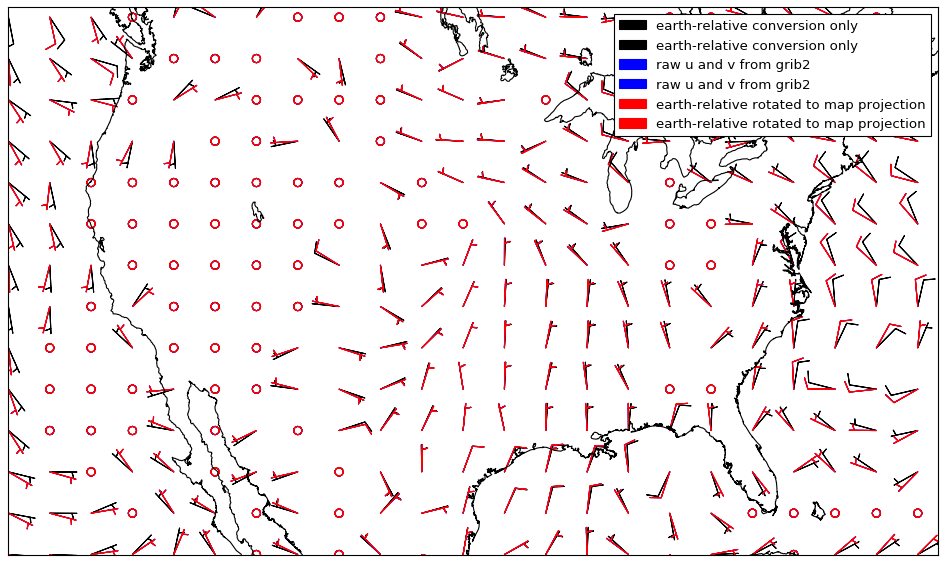

In [32]:
plt.figure(figsize=[15, 10])

m.drawcoastlines()
thin = 80
m.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin], H['UGRD'][::thin,::thin],
        H['VGRD'][::thin,::thin],label='earth-relative conversion only', latlon=True)
m.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin], Hu['value'][::thin,::thin],
        Hv['value'][::thin,::thin], latlon=True, color='b', label='raw u and v from grib2')

u10_rot, v10_rot = m.rotate_vector(H['UGRD'], H['VGRD'], Hv['lon'], Hv['lat'])
m.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin], u10_rot[::thin,::thin], v10_rot[::thin,::thin],
        label='earth-relative rotated to map projection', latlon=True, color='r')

plt.legend()

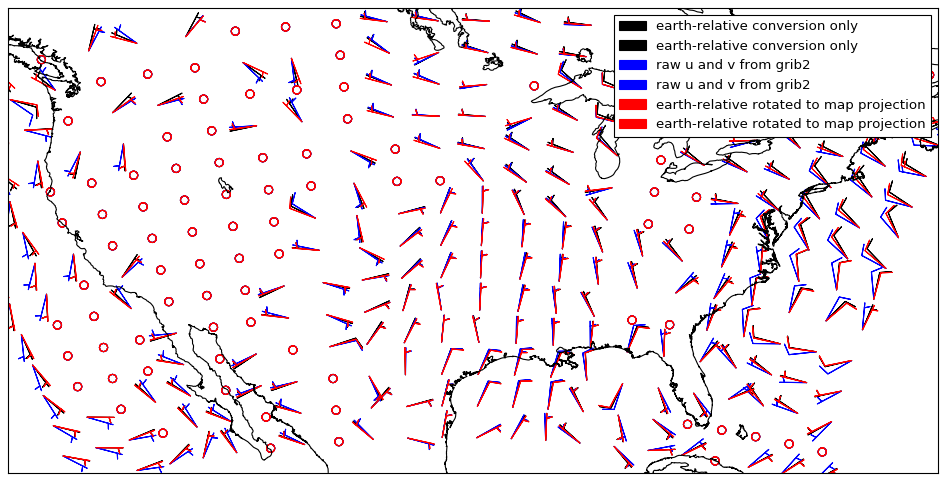

In [35]:
plt.figure(figsize=[15, 10])

mcyl.drawcoastlines()
thin = 80
mcyl.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin], H['UGRD'][::thin,::thin],
        H['VGRD'][::thin,::thin],label='earth-relative conversion only', latlon=True)
mcyl.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin], Hu['value'][::thin,::thin],
        Hv['value'][::thin,::thin], latlon=True, color='b', label='raw u and v from grib2')

u10_rot, v10_rot = mcyl.rotate_vector(H['UGRD'], H['VGRD'], Hv['lon'], Hv['lat'])
mcyl.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin], u10_rot[::thin,::thin], v10_rot[::thin,::thin],
        label='earth-relative rotated to map projection', latlon=True, color='r')

plt.legend()

So...plotting the earth-relative grib2 file with `rotate_vector` (red barbs) is the same as plotting the raw model U and V unrotated (blue barbs covered by red barbs)??

Black is the straight earth-relative grid2 converted data

https://basemaptutorial.readthedocs.io/en/latest/utilities.html#rotate-vector

> `uin` and `vin` are the input data matrices. The directions are the geographical, so the u component is west-east and the v component, north-south

Thus, the input must be the earth-relative converted wind, then the rotate vecotr must be performed.

In [20]:
DATE = datetime(2018, 6, 1)
ak_H = get_hrrr_variable(DATE, 'UVGRD:10 m', model='hrrrak', verbose=False)
ak_Hu = get_hrrr_variable(DATE, 'UGRD:10 m', model='hrrrak', verbose=False)
ak_Hv = get_hrrr_variable(DATE, 'VGRD:10 m', model='hrrrak', verbose=False)

In [24]:
print ak_H.keys()
print ak_Hu.keys()

['URL', 'units', 'VGRD', 'lat', 'name', 'level', 'lon', 'UGRD', 'valid', 'msg', 'SPEED', 'anlys']
['msg', 'units', 'valid', 'anlys', 'level', 'lat', 'lon', 'URL', 'value', 'name']


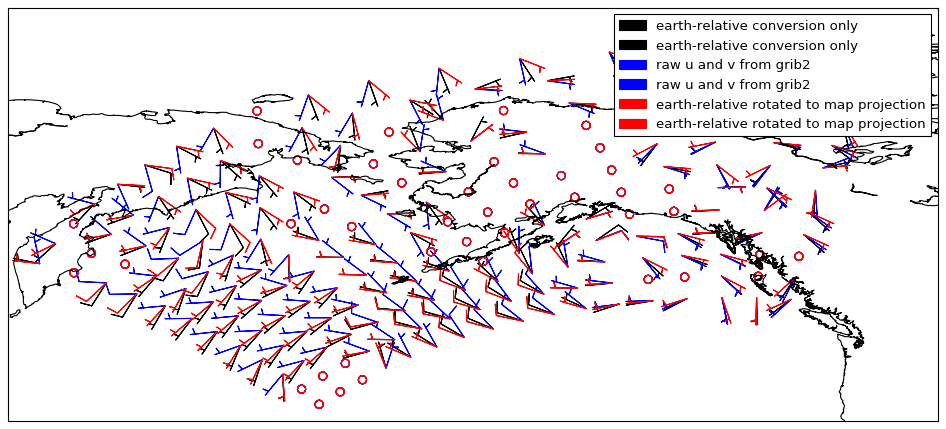

In [30]:
plt.figure(figsize=[15, 10])

mak.drawcoastlines()
thin = 80
mak.barbs(ak_H['lon'][::thin,::thin], ak_H['lat'][::thin,::thin],
          ak_H['UGRD'][::thin,::thin], ak_H['VGRD'][::thin,::thin],
          label='earth-relative conversion only',
          latlon=True)
mak.barbs(ak_H['lon'][::thin,::thin], ak_H['lat'][::thin,::thin],
          ak_Hu['value'][::thin,::thin], ak_Hv['value'][::thin,::thin],
          label='raw u and v from grib2',
          latlon=True, color='b')

ak_u10_rot, ak_v10_rot = mak.rotate_vector(ak_H['UGRD'], ak_H['VGRD'],
                                           ak_Hv['lon'], ak_Hv['lat'])
mak.barbs(ak_H['lon'][::thin,::thin], ak_H['lat'][::thin,::thin],
          ak_u10_rot[::thin,::thin],  ak_v10_rot[::thin,::thin],
          label='earth-relative rotated to map projection',
          latlon=True, color='r')

plt.legend()